## Survival analysis for Park et al. classes

For now, we'll just consider samples with a point mutation and CNV as "two-hit" samples, and samples with either but not both as "one-hit" samples. We could make this more granular in the future (i.e. use multiple point mutations as evidence of "two-hitness", or deep CNVs as "two-hit" samples as well).

In [1]:
from pathlib import Path
import pickle as pkl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

import sys; sys.path.append('..')
import config as cfg

In [2]:
MPMP_LOCATION = Path('/home/jake/research/mpmp')

# park et al. geneset info
park_loss_data = cfg.data_dir / 'park_loss_df.tsv'
park_gain_data = cfg.data_dir / 'park_gain_df.tsv'

# park et al. significant gene info
park_loss_sig_data = cfg.data_dir / 'park_loss_df_sig_only.tsv'
park_gain_sig_data = cfg.data_dir / 'park_gain_df_sig_only.tsv'

MIN_N_MUTATED = 0
MAX_MIN_PVAL = 0.05

### Load information for Park et al. genes

In [3]:
park_loss_df = pd.read_csv(park_loss_data, sep='\t', index_col=0)
park_loss_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ACVR1_UCEC,ACVR1,UCEC,0.000000,0.997445,0.681521,0.166514,B_Target,Oncogene
ACVR2A_COADREAD,ACVR2A,COADREAD,0.000000,0.997631,0.681315,0.166646,B_Target,TSG
ACVR2A_LIHC,ACVR2A,LIHC,-1.000178,0.040008,0.122307,0.912515,B_Target,TSG
AJUBA_HNSC,AJUBA,HNSC,-0.936050,0.008733,0.045816,1.338886,A_Hit,TSG
AKT1_BRCA,AKT1,BRCA,0.000000,0.997163,0.681829,0.166318,B_Target,Oncogene


In [4]:
park_gain_df = pd.read_csv(park_gain_data, sep='\t', index_col=0)
park_gain_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ACVR1_UCEC,ACVR1,UCEC,-0.482699,0.370095,0.571956,0.242630,B_Target,Oncogene
ACVR2A_COADREAD,ACVR2A,COADREAD,0.187531,0.753981,0.780954,0.107369,B_Target,TSG
ACVR2A_LIHC,ACVR2A,LIHC,0.163421,0.834858,0.821548,0.085362,B_Target,TSG
AJUBA_HNSC,AJUBA,HNSC,0.711518,0.026392,0.147049,0.832509,B_Target,TSG
AKT1_BRCA,AKT1,BRCA,0.535765,0.092176,0.312738,0.504805,B_Target,Oncogene


In [5]:
park_loss_sig_df = pd.read_csv(park_loss_sig_data, sep='\t', index_col=0)
park_loss_sig_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
AJUBA_HNSC,AJUBA,HNSC,-0.936050,8.732955e-03,0.045816,1.338886,A_Hit,TSG
ARID1A_LGG,ARID1A,LGG,-0.904202,1.956617e-02,0.076291,1.117471,A_Hit,TSG
ARID1A_STAD,ARID1A,STAD,1.133548,3.979932e-04,0.000294,3.517309,B_Target,TSG
ARID1A_UCEC,ARID1A,UCEC,1.597876,3.451937e-07,0.000000,5.000000,B_Target,TSG
ARID2_LIHC,ARID2,LIHC,-0.978419,1.019284e-02,0.050276,1.298552,A_Hit,TSG


In [6]:
park_gain_sig_df = pd.read_csv(park_gain_sig_data, sep='\t', index_col=0)
park_gain_sig_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ARID1A_UCEC,ARID1A,UCEC,-2.351526,1.154365e-03,-0.000447,3.340299,B_Target,TSG
ATRX_LGG,ATRX,LGG,1.440987,4.025141e-08,0.000000,5.000000,A_Hit,TSG
BRAF_SKCM,BRAF,SKCM,1.239939,2.042839e-11,0.000000,5.000000,A_Hit,Oncogene
BRAF_THCA,BRAF,THCA,-2.449684,7.509064e-04,-0.000209,3.659041,B_Target,Oncogene
CTNNB1_UCEC,CTNNB1,UCEC,-1.257861,1.597968e-02,0.096292,1.016366,B_Target,Oncogene


### Get clinical endpoint info

Code for preprocessing clinical info is based on: https://github.com/greenelab/mpmp/blob/master/mpmp/utilities/data_utilities.py#L510

TODO: move this to a function/utilities file

In [7]:
# use TCGA clinical data downloaded in mpmp repo
clinical_filename = (
    MPMP_LOCATION / 'data' / 'raw' / 'TCGA-CDR-SupplementalTableS1.xlsx'
)

In [8]:
clinical_df = pd.read_excel(
    clinical_filename,
    sheet_name='TCGA-CDR',
    index_col='bcr_patient_barcode',
    engine='openpyxl'
)

clinical_df.index.rename('patient_id', inplace=True)

# drop numeric index column
clinical_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

# we want to use age as a covariate
clinical_df.rename(columns={'age_at_initial_pathologic_diagnosis': 'age'},
                   inplace=True)

print(clinical_df.shape)
clinical_df.iloc[:5, :5]

(11160, 32)


,type,age,gender,race,ajcc_pathologic_tumor_stage
patient_id,,,,,
TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II
TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV
TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III
TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV
TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III


In [9]:
# we want to use overall survival as the target variable except for
# certain cancer types where progression-free intervals are typically
# used (since very few deaths are observed)
# this is recommended in https://doi.org/10.1016/j.cell.2018.02.052
pfi_cancer_types = [
    'BRCA', 'DLBC', 'LGG', 'PCPG', 'PRAD',
    'READ', 'TGCT', 'THCA', 'THYM'
]

clinical_df['time_in_days'] = clinical_df['OS.time']
clinical_df['status'] = clinical_df['OS'].astype('bool')

pfi_samples = clinical_df.type.isin(pfi_cancer_types)
clinical_df.loc[pfi_samples, 'time_in_days'] = clinical_df[pfi_samples]['PFI.time']
clinical_df.loc[pfi_samples, 'status'] = clinical_df[pfi_samples]['PFI'].astype('bool')

# clean up columns and drop samples with NA survival times
na_survival_times = (clinical_df['time_in_days'].isna())
cols_to_keep = ['status', 'time_in_days', 'type']
clinical_df = clinical_df.loc[~na_survival_times, cols_to_keep].copy()

print(clinical_df.shape)
clinical_df.head()

(11094, 3)


,status,time_in_days,type
patient_id,,,
TCGA-OR-A5J1,True,1355.0,ACC
TCGA-OR-A5J2,True,1677.0,ACC
TCGA-OR-A5J3,False,2091.0,ACC
TCGA-OR-A5J4,True,423.0,ACC
TCGA-OR-A5J5,True,365.0,ACC


### Get mutated samples info

In [10]:
# mutation and copy number data
pancancer_pickle = MPMP_LOCATION / 'data' / 'pancancer_data.pkl'

with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)

In [11]:
# get (binary) mutation data
# 1 = observed non-silent mutation in this gene for this sample, 0 otherwise
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [12]:
# we use the data source and preprocessing code from the pancancer repo, here:
# https://github.com/greenelab/pancancer/blob/d1b3de7fa387d0a44d0a4468b0ac30918ed66886/scripts/initialize/process_copynumber.py#L21

copy_thresh_df = (
    pd.read_csv(cfg.data_dir / 'pancan_GISTIC_threshold.tsv',
                sep='\t', index_col=0)
      .drop(columns=['Locus ID', 'Cytoband'])
)
copy_thresh_df.columns = copy_thresh_df.columns.str[0:15]

# thresholded copy number includes 5 values [-2, -1, 0, 1, 2], which
# correspond to "deep loss", "moderate loss", "no change",
# "moderate gain", and "deep gain", respectively.
print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(25128, 10713)


,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J4-01,TCGA-OR-A5J5-01
Gene Symbol,,,,,
ACAP3,0,0,0,1,0
ACTRT2,0,0,0,1,0
AGRN,0,0,0,1,0
ANKRD65,0,0,0,1,0
ATAD3A,0,0,0,1,0


In [13]:
sample_freeze_df = pancancer_data[0]
copy_samples = list(
    set(sample_freeze_df.SAMPLE_BARCODE)
    .intersection(set(copy_thresh_df.columns))
)
print(len(copy_samples))

9068


In [14]:
# make sure we're not losing too many samples, a few is fine
print(sorted(set(sample_freeze_df.SAMPLE_BARCODE) - set(copy_thresh_df.columns)))

['TCGA-06-0152-02', 'TCGA-06-0171-02', 'TCGA-06-0221-02', 'TCGA-14-0736-02', 'TCGA-ER-A19T-01', 'TCGA-ER-A2NF-01']


In [15]:
copy_thresh_df = (copy_thresh_df
    .T
    .loc[sorted(copy_samples)]
    .fillna(0)
    .astype(int)
)

print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,-1,-1,-1,-1,-1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [16]:
# here, we want to use "moderate" and "deep" loss/gain to define CNV
# loss/gain (to match Park et al.)
#
# note that this is different to the more conservative approach of using
# "deep loss/gain" only as in our classifiers

copy_loss_df = (copy_thresh_df
    .replace(to_replace=[1, 2], value=0)
    .replace(to_replace=[-1, -2], value=1)
)
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,1,1,1,1,1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [17]:
copy_gain_df = (copy_thresh_df
    .replace(to_replace=[-1, -2], value=0)
    .replace(to_replace=[1, 2], value=1)
)
print(copy_gain_df.shape)
copy_gain_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### Get sample info and groups for gene/cancer type

In [18]:
def get_groups_for_gene_and_tissue(identifier,
                                   cancer_classification,
                                   hits_classification):
    """Given a gene and tissue, load the relevant mutation/CNV information,
    and divide the samples into groups to compare survival.
    
    cancer_classification is the classification of the gene as "Oncogene" or
    "TSG", hits_classification is the classification of the gene as "one" (a
    one-hit gene) or "two" (a 2+-hit gene).
    """
    # get patient ids (first 12 of TCGA identifier) with mutation info
    mut_patient_ids = mutation_df.index.str[:12]
    
    # get patient ids in given cancer type 
    gene, tissue = identifier.split('_')
    if tissue == 'COADREAD':
        tissue_ids = (clinical_df
            .query('type == "COAD" or type == "READ"')
            .index
            .intersection(mut_patient_ids)
        )
    else:
        tissue_ids = (clinical_df
            .query('type == @tissue')
            .index
            # mutation_df and the CNV dfs have the same index, so we
            # only have to check this one rather than all of them
            .intersection(mut_patient_ids)
        )
    id_clinical_df = clinical_df.loc[tissue_ids, :].copy()
    
    # get mutation and copy status
    mutation_status = mutation_df.loc[
        mutation_df.index.str[:12].isin(mut_patient_ids), gene
    ]
    if cancer_classification == 'TSG':
        copy_status = copy_loss_df.loc[
            copy_loss_df.index.str[:12].isin(mut_patient_ids), gene
        ]
    elif cancer_classification == 'Oncogene':
        copy_status = copy_gain_df.loc[
            copy_gain_df.index.str[:12].isin(mut_patient_ids), gene
        ]
        
    mutation_status.index = mutation_status.index.str[:12]
    copy_status.index = copy_status.index.str[:12]
        
    # get groups from mutation/CNV data
    if hits_classification == 'one':
        id_clinical_df['is_mutated'] = (mutation_status | copy_status).astype(int)
        id_clinical_df['is_mutated_alt'] = (mutation_status & copy_status).astype(int)
    elif hits_classification == 'two':
        id_clinical_df['is_mutated'] = (mutation_status & copy_status).astype(int)
        id_clinical_df['is_mutated_alt'] = (mutation_status | copy_status).astype(int)
        
    return id_clinical_df

In [19]:
# test for a selected example
identifier = 'IDH1_LGG'
cancer_classification = 'Oncogene'
hits_classification = 'one'

id_clinical_df = get_groups_for_gene_and_tissue(
    identifier, cancer_classification, hits_classification)

print(id_clinical_df.shape)
print(id_clinical_df.is_mutated.sum(), id_clinical_df.is_mutated_alt.sum())
print(id_clinical_df.isna().sum()) 
id_clinical_df.head()

(505, 5)
399 5
status            0
time_in_days      0
type              0
is_mutated        0
is_mutated_alt    0
dtype: int64


,status,time_in_days,type,is_mutated,is_mutated_alt
TCGA-CS-4938,False,3574.0,LGG,1,0
TCGA-CS-4941,True,9.0,LGG,0,0
TCGA-CS-4942,True,1184.0,LGG,1,0
TCGA-CS-4943,True,1106.0,LGG,1,0
TCGA-CS-4944,False,1828.0,LGG,1,0


is_mutated chisq = 60.8130 p = 6.2762e-15
is_mutated_alt chisq = 0.4512 p = 5.0178e-01


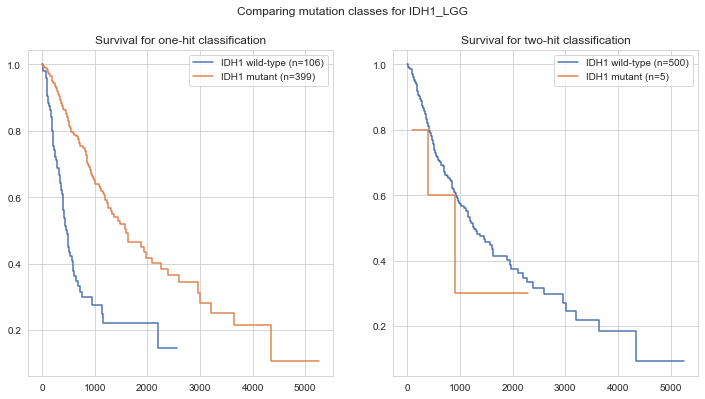

In [20]:
# plot groups
sns.set({'figure.figsize': (12, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

def plot_id(identifier, id_clinical_df):
    
    gene, tissue = identifier.split('_')

    for ix, mut_col in enumerate(['is_mutated', 'is_mutated_alt']):

        ax = axarr[ix]

        n_mutant = id_clinical_df[mut_col].sum()
        n_wildtype = id_clinical_df.shape[0] - n_mutant

        for is_mutated in sorted(id_clinical_df[mut_col].unique()):
            mask_mutated = (id_clinical_df[mut_col] == is_mutated)
            time_treatment, survival_prob_treatment = kaplan_meier_estimator(
                id_clinical_df['status'][mask_mutated],
                id_clinical_df['time_in_days'][mask_mutated]
            )

            def get_label(gene, is_mutated, n_mutant, n_wildtype):
                if is_mutated:
                    return '{} mutant (n={})'.format(gene, n_mutant)
                else:
                    return '{} wild-type (n={})'.format(gene, n_wildtype)

            # TODO: confidence intervals
            ax.step(time_treatment, survival_prob_treatment, where="post",
                    label=get_label(gene, is_mutated, n_mutant, n_wildtype))

        ax.legend()

        def get_n_hits(hits_class, ix):
            hits_desc = (['one', 'two'] if hits_class == 'one' else ['two', 'one'])
            return hits_desc[ix]

        ax.set_title('Survival for {}-hit classification'.format(
            get_n_hits(hits_classification, ix)))

        # hypothesis testing using log-rank test
        y = Surv.from_dataframe('status', 'time_in_days', id_clinical_df)
        chisq, p_val = compare_survival(y, id_clinical_df[mut_col].values)
        print(mut_col, 'chisq = {:.4f}'.format(chisq), 'p = {:.4e}'.format(p_val))

    plt.suptitle('Comparing mutation classes for {}'.format(identifier))
    
plot_id(identifier, id_clinical_df)

### Run for all "class 2" genes

These are all tumor suppressors that Park et al. have annotated as "two-hit loss" drivers (i.e. classical tumor suppressors).

We want to see how many of them (if any) distinguish between survival groups more effectively for two-hit samples as opposed to one-hit samples. On average, if their classes make sense we would expect to see that a comparison between two-hit samples and all other samples gives us "better" survival groups than a comparison between 1+ hit samples and 0-hit samples.

We'll quantify "better" using a log-rank test with the above groups, and look at the difference in test statistics. This is going to be somewhat dependent on sample size but it should give us a general idea of whether or not there's any survival-related signal in these mutation groups across genes/cancer types.

In [21]:
class_2_ids = park_loss_sig_df.index.unique()
print(len(class_2_ids))
print(class_2_ids[:10])

79
Index(['AJUBA_HNSC', 'ARID1A_LGG', 'ARID1A_STAD', 'ARID1A_UCEC', 'ARID2_LIHC',
       'BAP1_KIRP', 'BAP1_LIHC', 'BCOR_UCEC', 'BRD7_LIHC', 'CDH1_BRCA'],
      dtype='object')


We want to build a dataframe with:
* identifier
* \# WT samples
* \# mutant samples
* survival p-value
* \# WT samples (alt classification)
* \# mutant samples (alt classification)
* survival p-value (alt classification)

In [22]:
class_2_surv_df = []
columns = [
    'identifier',
    'n_mutant',
    'n_wildtype',
    'chisq',
    'p_val',
    'n_mutant_alt',
    'n_wildtype_alt',
    'chisq_alt',
    'p_val_alt',
]

for identifier in class_2_ids:
    
    results = [identifier]
    
    id_clinical_df = get_groups_for_gene_and_tissue(
        identifier, 'TSG', 'two')
    
    for ix, mut_col in enumerate(['is_mutated', 'is_mutated_alt']):
    
        n_mutant = id_clinical_df[mut_col].sum()
        n_wildtype = id_clinical_df.shape[0] - n_mutant
        
        if n_mutant < 2 or n_wildtype < 2:
            print(identifier, mut_col, n_mutant, n_wildtype, file=sys.stderr)
            continue
    
        # hypothesis testing using log-rank test
        y = Surv.from_dataframe('status', 'time_in_days', id_clinical_df)
        chisq, p_val = compare_survival(y, id_clinical_df[mut_col].values)
        results += [n_mutant, n_wildtype, chisq, p_val]
        
    if len(results) == len(columns):
        class_2_surv_df.append(results)
        
class_2_surv_df = pd.DataFrame(
    class_2_surv_df,
    columns=columns
)
class_2_surv_df.set_index('identifier')

class_2_surv_df['ts_diff'] = class_2_surv_df.chisq - class_2_surv_df.chisq_alt
class_2_surv_df['p_val_diff'] = class_2_surv_df.p_val - class_2_surv_df.p_val_alt

print(class_2_surv_df.shape)

CTNNB1_UCEC is_mutated 1 505
PTPDC1_LAML is_mutated 1 106
RUNX1_LAML is_mutated 1 106
SIN3A_UCEC is_mutated 1 505


(75, 11)


In [23]:
# filter to genes that have at least MIN_N_MUTATED mutated samples
if MIN_N_MUTATED > 0:
    class_2_surv_df = (class_2_surv_df
        .loc[(class_2_surv_df.n_mutant > MIN_N_MUTATED) &
             (class_2_surv_df.n_wildtype > MIN_N_MUTATED) &
             (class_2_surv_df.n_mutant_alt > MIN_N_MUTATED) &
             (class_2_surv_df.n_wildtype_alt > MIN_N_MUTATED), :]
    ).copy()
    
if MAX_MIN_PVAL is not None:
    class_2_surv_df['min_pval'] = class_2_surv_df[['p_val', 'p_val_alt']].min(axis=1)
    class_2_surv_df = class_2_surv_df[class_2_surv_df.min_pval < MAX_MIN_PVAL].copy()
    
print(class_2_surv_df.shape)
class_2_surv_df.sort_values(by='ts_diff', ascending=False).head(20)

(20, 12)


,identifier,n_mutant,n_wildtype,chisq,p_val,n_mutant_alt,n_wildtype_alt,chisq_alt,p_val_alt,ts_diff,p_val_diff,min_pval
14,CUL3_KIRP,3,267,18.623700,1.592287e-05,18,252,0.069411,7.921960e-01,18.554289,-7.921801e-01,1.592287e-05
59,TP53_LAML,4,103,19.450035,1.032659e-05,17,90,3.425565,6.419427e-02,16.024470,-6.418395e-02,1.032659e-05
68,TP53_THYM,2,116,19.529491,9.905851e-06,17,101,3.703357,5.430312e-02,15.826135,-5.429322e-02,9.905851e-06
51,SMARCA4_LUAD,30,463,6.482451,1.089446e-02,274,219,0.532422,4.655905e-01,5.950030,-4.546961e-01,1.089446e-02
33,NSD1_HNSC,34,453,4.262560,3.896117e-02,211,276,0.288571,5.911378e-01,3.973989,-5.521767e-01,3.896117e-02
28,NF1_LGG,6,499,27.288500,1.752506e-07,47,458,24.441636,7.659533e-07,2.846864,-5.907027e-07,1.752506e-07
69,TP53_UCEC,105,401,20.395459,6.297907e-06,206,300,18.614631,1.599879e-05,1.780827,-9.700888e-06,6.297907e-06
48,RB1_LIHC,15,332,4.133091,4.205247e-02,175,172,4.489543,3.410278e-02,-0.356452,7.949685e-03,3.410278e-02
64,TP53_PRAD,49,430,4.406500,3.580222e-02,170,309,5.932959,1.486027e-02,-1.526459,2.094195e-02,1.486027e-02
53,STK11_LUAD,47,446,1.471115,2.251699e-01,287,206,4.127227,4.219845e-02,-2.656112,1.829715e-01,4.219845e-02


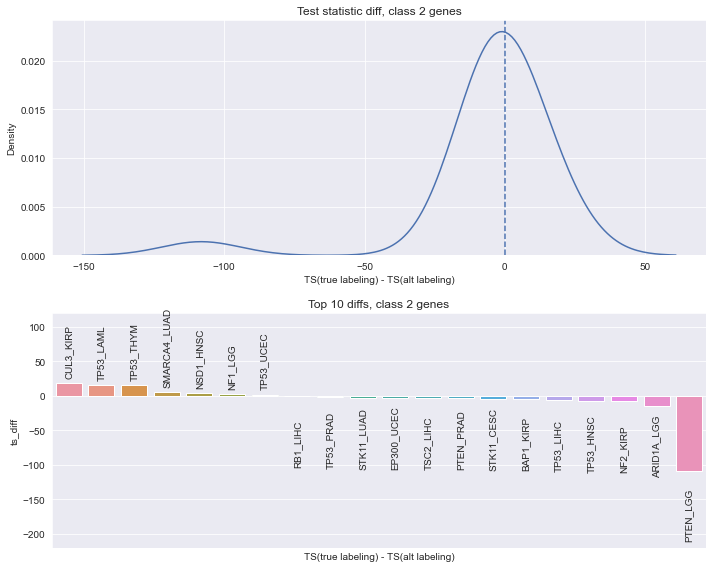

In [24]:
sns.set({'figure.figsize': (10, 8)})
fig, axarr = plt.subplots(2, 1)

sns.kdeplot(data=class_2_surv_df.ts_diff, ax=axarr[0])
axarr[0].axvline(0, linestyle='--')
axarr[0].set_title('Test statistic diff, class 2 genes')
axarr[0].set_xlabel('TS(true labeling) - TS(alt labeling)')

metric = 'ts'
num_examples = 10

top_df = (class_2_surv_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .head(num_examples)
)
bottom_df = (class_2_surv_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .tail(num_examples)
)
plot_df = pd.concat((top_df, bottom_df)).reset_index()
sns.barplot(data=plot_df, x=plot_df.index, y='{}_diff'.format(metric),
            dodge=False, ax=axarr[1])
axarr[1].set_xticks([])
axarr[1].set_title('Top 10 diffs, class 2 genes')
axarr[1].set_xlabel('TS(true labeling) - TS(alt labeling)')

def show_values_on_bars(ax):
    for i in range(plot_df.shape[0]):
        _x = i
        _y = plot_df.loc[i, '{}_diff'.format(metric)]
        val = plot_df.loc[i, 'identifier']
        if _y > 0:
            ax.text(_x, _y + 10, val, ha="center", rotation=90) 
        else:
            ax.text(_x, _y - 100, val, ha="center", rotation=90)
            
axarr[1].set_ylim(-220, 120)
show_values_on_bars(axarr[1])

plt.tight_layout()

RB1_LIHC delta TS: -0.3565
is_mutated chisq = 4.1331 p = 4.2052e-02
is_mutated_alt chisq = 4.4895 p = 3.4103e-02


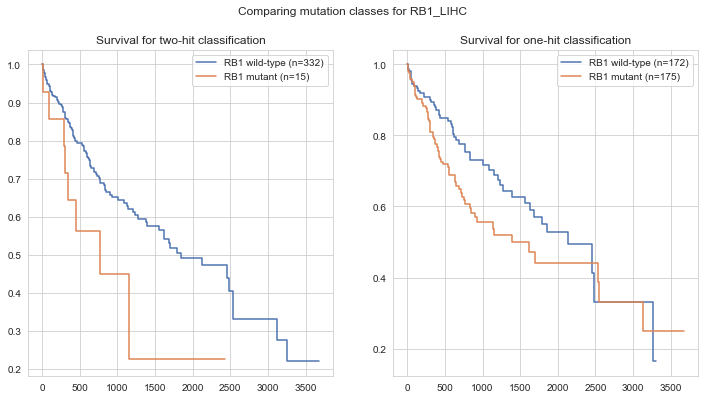

In [25]:
sns.set({'figure.figsize': (12, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

identifier = 'RB1_LIHC'
cancer_classification = 'TSG'
hits_classification = 'two'

id_clinical_df = get_groups_for_gene_and_tissue(
    identifier, cancer_classification, hits_classification)

print(identifier, r'delta TS:', '{:.4f}'.format(class_2_surv_df.loc[class_2_surv_df.identifier == identifier, 'ts_diff'].to_numpy()[0]))
plot_id(identifier, id_clinical_df)

So we can see that the "test statistic distribution" is centered around 0, meaning that in most cases either both classes distinguish similarly between survival groups, or neither do. If the "class 2" made sense as a survival marker we'd expect to see the distribution shifted to the right a bit, and we don't really see that.

In some cases we do see a bit of a survival difference, but most of them aren't huge, and many are likely affected by sample size (in other words, if we only have a few two-hit samples the test statistic is never going to be large, e.g. PTEN_LGG).

### Run for all "class 1" tumor suppressors

In Park et al, "class 1" tumor suppressors are "one-hit" genes, meaning a single mutation (point mutation or CNV) should contribute to cancer initiation/development.

Like before, we'll look at the difference between 1+ hits vs 0, and 2 hits vs. 0 or 1. Positive test statistic differences indicates that the one-hit classification gives "better" survival groups, and vice-versa.

In [26]:
class_1_ids = (
    park_loss_df[park_loss_df.classification == 'TSG']
      .index.unique()
      .difference(park_loss_sig_df.index)
)
    
print(len(class_1_ids))
print(class_1_ids[:10])

213
Index(['ACVR2A_COADREAD', 'ACVR2A_LIHC', 'ALB_LIHC', 'AMER1_COADREAD',
       'APC_COADREAD', 'APC_STAD', 'APOB_LIHC', 'ARHGAP35_LUSC',
       'ARHGAP35_UCEC', 'ARID1A_BLCA'],
      dtype='object')


In [27]:
class_1_surv_df = []
columns = [
    'identifier',
    'n_mutant',
    'n_wildtype',
    'chisq',
    'p_val',
    'n_mutant_alt',
    'n_wildtype_alt',
    'chisq_alt',
    'p_val_alt',
]

for identifier in class_1_ids:
    
    results = [identifier]
    
    id_clinical_df = get_groups_for_gene_and_tissue(
        identifier, 'TSG', 'one')
    
    for ix, mut_col in enumerate(['is_mutated', 'is_mutated_alt']):
    
        n_mutant = id_clinical_df[mut_col].sum()
        n_wildtype = id_clinical_df.shape[0] - n_mutant
        
        if n_mutant < 2 or n_wildtype < 2:
            # statistical testing won't work in this case so just continue
            print(identifier, mut_col, n_mutant, n_wildtype, file=sys.stderr)
            continue
    
        # hypothesis testing using log-rank test
        y = Surv.from_dataframe('status', 'time_in_days', id_clinical_df)
        chisq, p_val = compare_survival(y, id_clinical_df[mut_col].values)
        results += [n_mutant, n_wildtype, chisq, p_val]
        
    if len(results) == len(columns):
        class_1_surv_df.append(results)
        
class_1_surv_df = pd.DataFrame(
    class_1_surv_df,
    columns=columns
)
class_1_surv_df.set_index('identifier')

class_1_surv_df['ts_diff'] = class_1_surv_df.chisq - class_1_surv_df.chisq_alt
class_1_surv_df['p_val_diff'] = class_1_surv_df.p_val - class_1_surv_df.p_val_alt

print(class_1_surv_df.shape)

APOB_LIHC is_mutated_alt 1 346
ARID1A_UCS is_mutated_alt 0 56
ARID5B_UCEC is_mutated_alt 0 506
ASXL1_LAML is_mutated_alt 0 107
ATF7IP_UCEC is_mutated_alt 0 506
ATRX_ACC is_mutated_alt 0 76
ATR_UCEC is_mutated_alt 0 506
BCOR_STAD is_mutated_alt 1 377
BTG2_DLBC is_mutated_alt 1 36
CASP8_STAD is_mutated_alt 1 377
CD70_DLBC is_mutated_alt 0 37
CDKN2A_LIHC is_mutated_alt 1 346
CHD3_UCEC is_mutated_alt 1 505
CTNND1_UCEC is_mutated_alt 1 505
DNMT3A_LAML is_mutated_alt 0 107
IL6ST_LIHC is_mutated_alt 0 347
INPPL1_UCEC is_mutated_alt 1 505
KANSL1_BLCA is_mutated_alt 1 396
KANSL1_UCEC is_mutated_alt 0 506
KDM5C_KIRC is_mutated_alt 0 352
KDM6A_KIRP is_mutated_alt 0 270
KDM6A_PAAD is_mutated_alt 1 151
KMT2B_UCEC is_mutated_alt 0 506
KMT2C_UCEC is_mutated_alt 0 506
MAP3K4_UCS is_mutated_alt 0 56
MSH6_UCEC is_mutated_alt 0 506
NIPBL_LGG is_mutated_alt 1 504
NOTCH1_LGG is_mutated_alt 1 504
NSD1_ESCA is_mutated_alt 1 168
NUP133_LIHC is_mutated_alt 0 347
PBRM1_UCEC is_mutated_alt 1 505
PIK3R1_GBM is_mu

(170, 11)


TXNIP_BLCA is_mutated_alt 1 396
ZBTB20_LGG is_mutated_alt 1 504
ZBTB7B_UCS is_mutated_alt 0 56
ZFP36L2_COADREAD is_mutated_alt 0 456


In [28]:
# filter to genes that have at least MIN_N_MUTATED mutated samples
if MIN_N_MUTATED > 0:
    class_1_surv_df = (class_1_surv_df
        .loc[(class_1_surv_df.n_mutant > MIN_N_MUTATED) &
             (class_1_surv_df.n_wildtype > MIN_N_MUTATED) &
             (class_1_surv_df.n_mutant_alt > MIN_N_MUTATED) &
             (class_1_surv_df.n_wildtype_alt > MIN_N_MUTATED), :]
    ).copy()
    
if MAX_MIN_PVAL is not None:
    class_1_surv_df['min_pval'] = class_1_surv_df[['p_val', 'p_val_alt']].min(axis=1)
    class_1_surv_df = class_1_surv_df[class_1_surv_df.min_pval < MAX_MIN_PVAL].copy()
    
print(class_1_surv_df.shape)
class_1_surv_df.sort_values(by='ts_diff', ascending=False).head(20)

(28, 12)


,identifier,n_mutant,n_wildtype,chisq,p_val,n_mutant_alt,n_wildtype_alt,chisq_alt,p_val_alt,ts_diff,p_val_diff,min_pval
75,FUBP1_LGG,182,323,25.438442,4.567256e-07,45,460,1.184855,0.276370,24.253587,-0.276369,4.567256e-07
33,BAP1_UVM,44,36,19.136826,1.216744e-05,13,67,0.383079,0.535960,18.753748,-0.535948,1.216744e-05
43,CDKN2A_HNSC,352,135,9.782349,1.761951e-03,42,445,0.009775,0.921244,9.772574,-0.919482,1.761951e-03
156,TGFBR2_HNSC,356,131,5.918580,1.498203e-02,13,474,0.000155,0.990075,5.918425,-0.975093,1.498203e-02
88,KMT2D_DLBC,13,24,5.703863,1.692762e-02,2,35,0.039322,0.842813,5.664541,-0.825885,1.692762e-02
169,ZNF750_ESCA,46,123,4.931253,2.637519e-02,5,164,0.486583,0.485456,4.444670,-0.459080,2.637519e-02
79,HUWE1_HNSC,172,315,4.106837,4.271017e-02,7,480,0.001095,0.973605,4.105742,-0.930895,4.271017e-02
93,LATS1_CESC,94,178,4.041492,4.439456e-02,7,265,1.743172,0.186737,2.298319,-0.142343,4.439456e-02
150,STAG2_BLCA,124,273,4.415066,3.562289e-02,11,386,2.188594,0.139036,2.226472,-0.103413,3.562289e-02
159,TP53_ACC,36,40,21.937623,2.816575e-06,8,68,20.520135,0.000006,1.417488,-0.000003,2.816575e-06


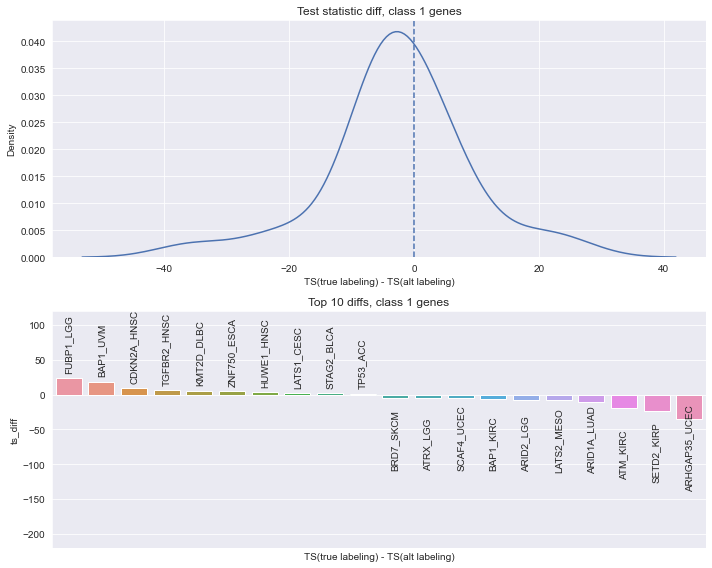

In [29]:
sns.set({'figure.figsize': (10, 8)})
fig, axarr = plt.subplots(2, 1)

sns.kdeplot(data=class_1_surv_df.ts_diff, ax=axarr[0])
axarr[0].axvline(0, linestyle='--')
axarr[0].set_title('Test statistic diff, class 1 genes')
axarr[0].set_xlabel('TS(true labeling) - TS(alt labeling)')

metric = 'ts'
num_examples = 10

top_df = (class_1_surv_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .head(num_examples)
)
bottom_df = (class_1_surv_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .tail(num_examples)
)
plot_df = pd.concat((top_df, bottom_df)).reset_index()
sns.barplot(data=plot_df, x=plot_df.index, y='{}_diff'.format(metric),
            dodge=False, ax=axarr[1])
axarr[1].set_xticks([])
axarr[1].set_title('Top 10 diffs, class 1 genes')
axarr[1].set_xlabel('TS(true labeling) - TS(alt labeling)')

def show_values_on_bars(ax):
    for i in range(plot_df.shape[0]):
        _x = i
        _y = plot_df.loc[i, '{}_diff'.format(metric)]
        val = plot_df.loc[i, 'identifier']
        if _y > 0:
            ax.text(_x, _y + 10, val, ha="center", rotation=90) 
        else:
            ax.text(_x, _y - 100, val, ha="center", rotation=90)
            
axarr[1].set_ylim(-220, 120)
show_values_on_bars(axarr[1])

plt.tight_layout()

ATRX_LGG delta TS: -5.4625
is_mutated chisq = 0.2338 p = 6.2873e-01
is_mutated_alt chisq = 5.6963 p = 1.7001e-02


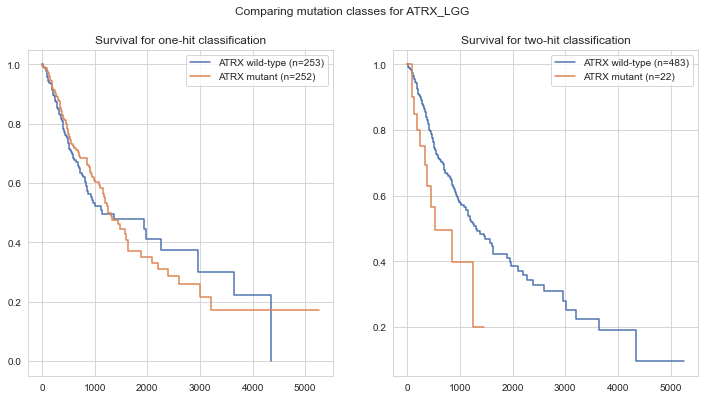

In [30]:
sns.set({'figure.figsize': (12, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

identifier = 'ATRX_LGG'
cancer_classification = 'TSG'
hits_classification = 'one'

id_clinical_df = get_groups_for_gene_and_tissue(
    identifier, cancer_classification, hits_classification)

print(identifier, r'delta TS:', '{:.4f}'.format(class_1_surv_df.loc[class_1_surv_df.identifier == identifier, 'ts_diff'].to_numpy()[0]))
plot_id(identifier, id_clinical_df)

For class 1 genes, when we filter to genes/cancer types with at least 1 p-value below 0.05, the distribution of test statistic differences has a mean < 0. This suggests that 2-hit samples actually tend to differentiate better between groups of patients having differential prognosis/survival than 1+-hit samples, for genes where there is a difference.

This could make sense for some examples; we'll have to think through it a bit.